In [a previous post](https://henryjchang.github.io/function-approximation-with-dl) we explored using vanilla gradient descent for linear regression in the process of motivating activation functions for nonlinear function approximation. We saw that while we were able to estimate reasonable parameters, it took a while for the loss to converge due to the problem of pathological curvature.  In this post we solve the linear regression problem with Newton's method, a second-order method, and experiment with various first-order optimizers that retain the speed of gradient descent while improving convergence by using heuristics that approximate the second order methods.

# Linear Regression with Vanilla Gradient Descent: The Problem of Pathological Curvature

This first section is copied directly from the previous post.

Lets explore unconstrained optimization algorithms with some example data. We consider the case of linear regression to some random data sampled from some ground truth parameters fitting an affine function with noise added in.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
!pip install einops
import einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.6 MB/s eta 0:00:00


In [6]:
params = np.array([5, 2])

num_samples = 100
x = np.linspace(-10,10,num_samples)

np.random.seed(5)
noise = np.random.normal(0, 3, num_samples)
y = params[0]*x + params[1] + noise

## Reusable Components

Lets create some reusable components for calculating loss and taking a gradient descent step.

In [7]:
def linear(X, w):
  return X @ w

def linear_grad(X, w):
  return X

In [8]:
def mse_loss(predictions, labels):
  return np.mean((predictions - labels)**2)

def mse_loss_grad(predictions, labels):
  return 2 * (predictions - labels) / len(predictions)

In [9]:
class LinearModelTrainer:
  def __init__(self, data, optimizer, num_epochs):
    self.data = data
    self.optimizer = optimizer
    self.epochs = num_epochs
    self.losses = []
    self.final_grad = None

  def train(self):
    for i in range(self.epochs):
      X = data['X']
      y = data['y']

      # Make predictions
      preds = linear(X, weights)

      # Calculate loss
      loss = mse_loss(preds, y)
      self.losses.append(loss)

      # Backpropagate
      mse_grad = einops.repeat(mse_loss_grad(preds, y), 'i -> i 1')
      lin_grad = linear_grad(X, weights)
      grad = mse_grad.transpose() @ lin_grad

      # Update weights
      self.optimizer.step(grad)

    # Keep track of final grad for observability
    self.final_grad = grad

  def get_grad(self):
    if self.final_grad is not None:
      return self.final_grad
    else:
      print("No gradients computed yet.")

  def get_losses(self):
    return self.losses

In [10]:
class GradientDescentOptimizer:
  def __init__(self, weights, lr):
    self.lr = lr
    self.weights = weights
    self.iterated_weights = [weights.copy()]

  def step(self, grad):
    # Update weights
    self.weights -= einops.rearrange(self.lr * grad, 'i j -> (i j)')
    # Keep track of weights for visualization
    self.iterated_weights.append(self.weights.copy())

  def get_weights(self):
    return self.iterated_weights

## Optimize with Gradient Descent

In [11]:
X = np.stack((x, np.ones_like(x)), axis=1)
data = {'X': X, 'y': y}

In [12]:
# random initialization
initial_weights = np.random.rand(2)
weights = initial_weights.copy()
print(weights)

[0.58937388 0.91473434]


In [13]:
optimizer = GradientDescentOptimizer(weights, lr=0.01)
trainer = LinearModelTrainer(data, optimizer, num_epochs=50)

In [14]:
trainer.train()

In [15]:
print("final weights: ", optimizer.get_weights()[-1])
print("final grads: ", trainer.get_grad())

final weights:  [5.00396765 1.77940355]
final grads:  [[ 2.42028619e-14 -1.01068650e+00]]


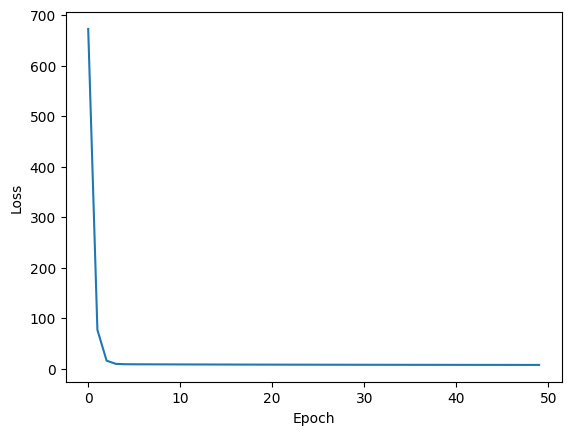

In [16]:
plt.plot(trainer.get_losses())
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

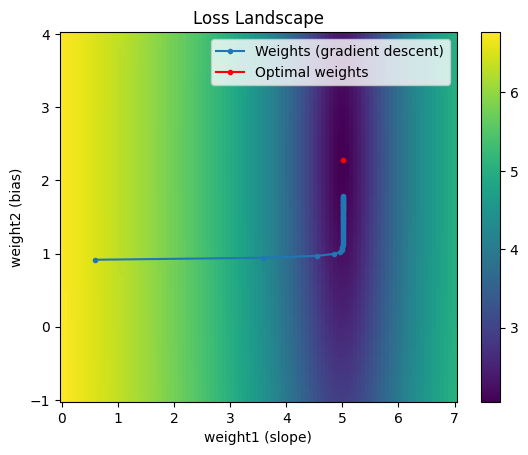

In [17]:
W1 = np.linspace(0, 7, 100)
W2 = np.linspace(-1, 4, 100)
log_loss = np.empty(shape=(100,100))

for i, w2 in enumerate(W2):
  for j, w1 in enumerate(W1):
    log_loss[i][j] = np.log(np.mean((w1*x + w2 - y)**2))


weights1, weights2 = np.meshgrid(W1, W2)
plt.pcolor(weights1, weights2, log_loss)
plt.colorbar()

# plot how gradient descent traversed the space
traversal = list(zip(*(optimizer.get_weights())))
plt.plot(traversal[0], traversal[1], marker='.', label='Weights (gradient descent)')

# plot optimal weights
min_loss_idx = np.argmin(log_loss)
i,j = min_loss_idx//100, min_loss_idx%100
plt.plot(W1[j], W2[i], 'r', marker='.', label='Optimal weights')

plt.xlabel('weight1 (slope)')
plt.ylabel('weight2 (bias)')
plt.title('Loss Landscape')
plt.legend()
plt.show()

With a learning rate of 0.01 and 30 epochs we find that once we enter the trough of the loss landscape the step size drastically decreases. This is the problem of pathological curvature.

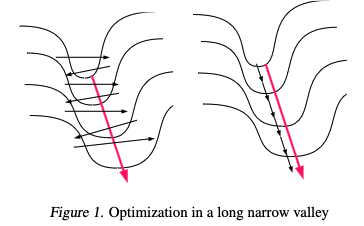

Instead of following the gradient down the trough, the loss bounces down the sides of the trough.

How can we avoid getting stuck in the trough? The gradients we use are bouncing along the sides of the trough. Instead of reducing the learning rate, which would reduce the amount of bouncing but simultaneously make the step sizes too small, we can leverage knowledge of the curvature of the loss function. We'll explore a powerful method that does just that next.

# Newton's Method

A popular optimization technique for taking the second derivative into account is Newton's Method. Recall that a function can be approximated to the nth order with its Taylor approximation. A 2nd order Taylor expansion of a function would be:

$ f(x + Δt) ≈ f(x) + f'(x)Δt + f''(x) \frac{Δt^{2}}{2}$

To find the $Δt$ that minimizes the above approximation, we can take the derivative w.r.t. $Δt$ and set it equal to zero:

$ 0 = \frac{d (f(x) + f'(x)Δt + f''(x) \frac{Δt^{2}}{2})}{d \Delta t} = f'(x) + f''(x) Δt$

So $Δt = -\frac{f'(x)}{f''(x)}$

So now the parameter update would be
$w_{k+1} = w_k + α Δt = w_k - α \frac{f'(x)}{f''(x)}$

where $α$ is the learning rate.

Recall in the case of linear regression with MSE loss, our loss function is
$L(x) = \frac{1}{n} ∑_{i=1}^{n}(f(x) - y)^2)$ and model is $f(p) = p_0x + p_1$.

$\frac{dL}{\partial p_i} = \frac{2}{n} ∑_{m=1}^{n}(f(p) - y)\frac{df}{dp_i}$

$\frac{d^2L}{\partial p_i \partial p_j} = \frac{2}{n} ∑_{m=1}^{n}\frac{\partial f}{\partial p_i}\frac{\partial f}{\partial p_j} + (f(p) - y)\frac{\partial^2 f}{\partial p_i \partial p_j}$

So taking the partial derivatives, we find our Hessian matrix is
$\frac{2}{n}\sum_{i=1}^n\begin{bmatrix}x_i^2 & x_i\\x_i & 1\end{bmatrix}$


Lets add the Hessian for our overall function to optimize.

In [34]:
def mse_linear_hessian(predictions, labels, X):
  x = X[:,0]
  n = len(x)
  mat = np.array([[x*x, x], \
                  [x,   np.ones_like(x)]])
  return 2 * np.mean(mat, axis=2)

In [35]:
class NewtonOptimizer:
  def __init__(self, weights, lr):
    self.lr = lr
    self.weights = weights
    self.iterated_weights = [weights.copy()]

  def step(self, grad, hessian):
    # Update weights
    grad = grad.reshape(-1,1)
    hessian_inv = np.linalg.inv(hessian)
    self.weights -= self.lr * (hessian_inv @ grad).reshape(-1)
    # Keep track of weights for visualization
    self.iterated_weights.append(self.weights.copy())

  def get_weights(self):
    return self.iterated_weights

We now need to compute the hessian as part of the backpropagation step of our trainer:

In [36]:
class LinearModelTrainerWithHessian:
  def __init__(self, data, optimizer, num_epochs):
    self.data = data
    self.optimizer = optimizer
    self.epochs = num_epochs
    self.losses = []
    self.final_grad = None

  def train(self):
    for i in range(self.epochs):
      X = data['X']
      y = data['y']

      # Make predictions
      preds = linear(X, weights)

      # Calculate loss
      loss = mse_loss(preds, y)
      self.losses.append(loss)

      # Backpropagate
      mse_grad = einops.repeat(mse_loss_grad(preds, y), 'i -> i 1')
      lin_grad = linear_grad(X, weights)
      grad = mse_grad.transpose() @ lin_grad
      hessian = mse_linear_hessian(preds, y, X) # needed for Newton's method

      # Update weights
      self.optimizer.step(grad, hessian)

    # Keep track of final grad for observability
    self.final_grad = grad

  def get_grad(self):
    if self.final_grad is not None:
      return self.final_grad
    else:
      print("No gradients computed yet.")

  def get_losses(self):
    return self.losses

In [37]:
# random initialization
weights = initial_weights.copy()
print(weights)

[0.58937388 0.91473434]


With Newton's Method, since we can leverage the curvature information we are much less likely to overshoot - we can increase the learning rate.

In [38]:
optimizer = NewtonOptimizer(weights, lr=0.1)
trainer = LinearModelTrainerWithHessian(data, optimizer, num_epochs=50)

In [39]:
trainer.train()

In [40]:
print("final weights: ", optimizer.get_weights()[-1])
print("final grads: ", trainer.get_grad())

final weights:  [4.98121583 2.26763128]
final grads:  [[-1.71936717 -0.01557477]]


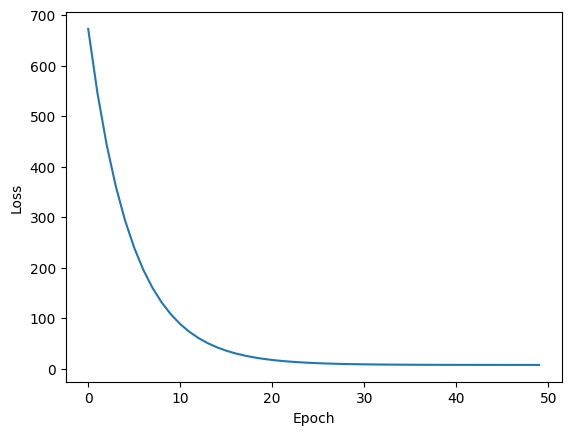

In [41]:
plt.plot(trainer.get_losses())
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

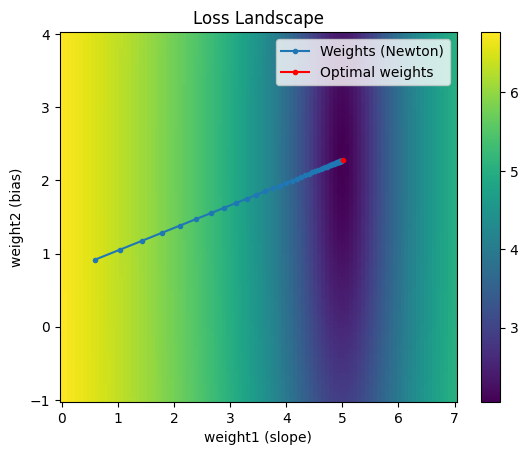

In [42]:
W1 = np.linspace(0, 7, 100)
W2 = np.linspace(-1, 4, 100)
log_loss = np.empty(shape=(100,100))

for i, w2 in enumerate(W2):
  for j, w1 in enumerate(W1):
    log_loss[i][j] = np.log(np.mean((w1*x + w2 - y)**2))


weights1, weights2 = np.meshgrid(W1, W2)
plt.pcolor(weights1, weights2, log_loss)
plt.colorbar()

# plot how gradient descent traversed the space
traversal = list(zip(*(optimizer.get_weights())))
plt.plot(traversal[0], traversal[1], marker='.', label='Weights (Newton)')

# plot optimal weights
min_loss_idx = np.argmin(log_loss)
i,j = min_loss_idx//100, min_loss_idx%100
plt.plot(W1[j], W2[i], 'r', marker='.', label='Optimal weights')

plt.xlabel('weight1 (slope)')
plt.ylabel('weight2 (bias)')
plt.title('Loss Landscape')
plt.legend()
plt.show()

Notice at each iteration the weights move much more directly toward the minimum. In fact, for this example, the 2nd order Taylor expansion is exactly equivalent to the original loss function. So we don't need to recompute a new 2nd order approximation around the current point at each iteration; instead, we can can get away with increasing the learning rate to 1.0 and get to the minimum in one iteration:

final weights:  [5.00396765 2.27463993]


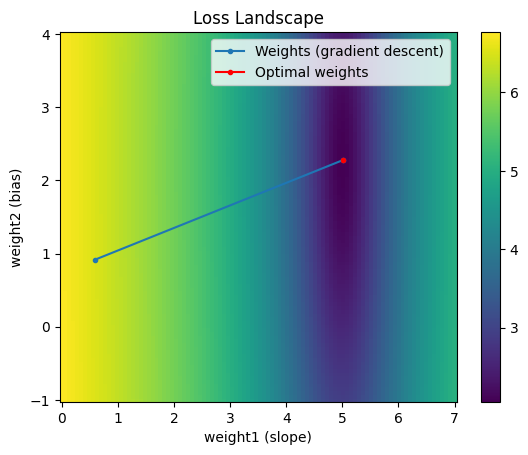

In [43]:
weights = initial_weights.copy()
optimizer = NewtonOptimizer(weights, lr=1.0)
trainer = LinearModelTrainerWithHessian(data, optimizer, num_epochs=1)
trainer.train()

print("final weights: ", optimizer.get_weights()[-1])

W1 = np.linspace(0, 7, 100)
W2 = np.linspace(-1, 4, 100)
log_loss = np.empty(shape=(100,100))

for i, w2 in enumerate(W2):
  for j, w1 in enumerate(W1):
    log_loss[i][j] = np.log(np.mean((w1*x + w2 - y)**2))


weights1, weights2 = np.meshgrid(W1, W2)
plt.pcolor(weights1, weights2, log_loss)
plt.colorbar()

# plot how gradient descent traversed the space
traversal = list(zip(*(optimizer.get_weights())))
plt.plot(traversal[0], traversal[1], marker='.', label='Weights (gradient descent)')

# plot optimal weights
min_loss_idx = np.argmin(log_loss)
i,j = min_loss_idx//100, min_loss_idx%100
plt.plot(W1[j], W2[i], 'r', marker='.', label='Optimal weights')

plt.xlabel('weight1 (slope)')
plt.ylabel('weight2 (bias)')
plt.title('Loss Landscape')
plt.legend()
plt.show()

This is great! Newton's method is really powerful. Why don't we use it for all our optimization problems?

Notice that the backpropagation step requires taking the 2nd derivatives with respect to parameters across layers. If there are $n$ parameters, the Hessian is of size $n^2$. In modern deep neural networks, there can be billions of parameters - the square of that many parameters is too many parameters to handle. Inverting the Hessian is also computationally expensive.

What can we do instead? There are a number of optimizers that approximate Newton's method without needing to compute a Hessian. We'll explore those next.

# Momentum

The momentum optimizer uses past gradient information as a heuristic for taking curvature information into account - it accumulates the change in gradients so far. It adds a decayed amount of past gradients to the current gradient such that oscillatory terms are cancelled out and terms in the same direction build on each other.

$σ_{i} = g_{i} + λσ_{i-1}$

$δ_{i} = -γσ_{i}$

$w_{i} = w_{i-1} + \delta_{i}$

where $g_i$ is the gradient at the current time step, $λ$ is the decay rate applied to past gradient sums, and $σ_i$ is the current gradient sum. $γ$ is the learning rate and $w$ is the set of parameters to update.

In [28]:
class MomentumOptimizer:
  def __init__(self, weights, lr, decay_rate):
    self.lr = lr
    self.decay_rate = decay_rate
    self.weights = weights
    self.iterated_weights = [weights.copy()]
    self.grad_sum = np.zeros_like(weights)

  def step(self, grad):
    # Update weights
    self.grad_sum = self.decay_rate * self.grad_sum + grad
    self.weights -= einops.rearrange(self.lr * self.grad_sum, 'i j -> (i j)')

    # Keep track of weights for visualization
    self.iterated_weights.append(self.weights.copy())

  def get_weights(self):
    return self.iterated_weights

In [29]:
weights = initial_weights.copy()
optimizer = MomentumOptimizer(weights, lr=0.01, decay_rate=0.5)
trainer = LinearModelTrainer(data, optimizer, num_epochs=50)
trainer.train()

In [30]:
print("final weights: ", optimizer.get_weights()[-1])
print("final grads: ", trainer.get_grad())

final weights:  [5.00396776 2.1060116 ]
final grads:  [[ 1.22309545e-05 -3.51978437e-01]]


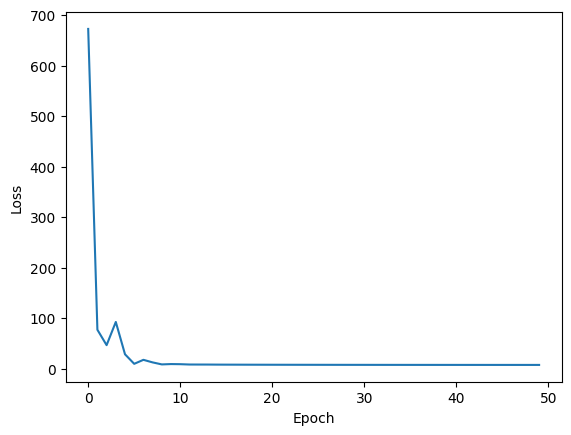

In [31]:
plt.plot(trainer.get_losses())
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

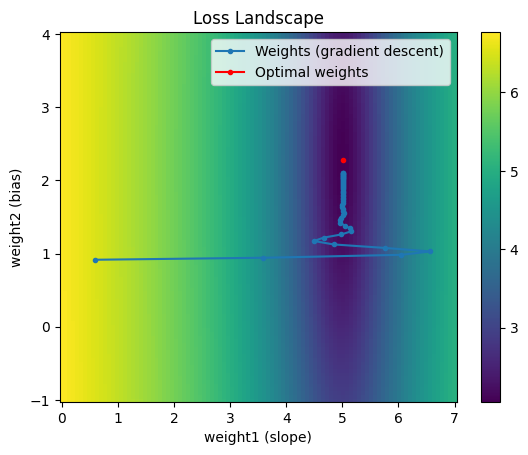

In [32]:
W1 = np.linspace(0, 7, 100)
W2 = np.linspace(-1, 4, 100)
log_loss = np.empty(shape=(100,100))

for i, w2 in enumerate(W2):
  for j, w1 in enumerate(W1):
    log_loss[i][j] = np.log(np.mean((w1*x + w2 - y)**2))


weights1, weights2 = np.meshgrid(W1, W2)
plt.pcolor(weights1, weights2, log_loss)
plt.colorbar()

# plot how gradient descent traversed the space
traversal = list(zip(*(optimizer.get_weights())))
plt.plot(traversal[0], traversal[1], marker='.', label='Weights (momentum)')

# plot optimal weights
min_loss_idx = np.argmin(log_loss)
i,j = min_loss_idx//100, min_loss_idx%100
plt.plot(W1[j], W2[i], 'r', marker='.', label='Optimal weights')

plt.xlabel('weight1 (slope)')
plt.ylabel('weight2 (bias)')
plt.title('Loss Landscape')
plt.legend()
plt.show()

Notice the weights after the first iteration are identical to those from vanilla gradient descent. However, after that step, the previous gradient information start to accumulate. This gives the effect of a ball rolling down the loss landscape. An additional benefit of momentum is that for a nonconvex loss landscape, it gives some possibility of escaping local minima if there is enough momentum.

# AdaGrad

AdaGrad is short for Adaptive Gradient. Instead of keeping track of the sum of gradients, it instead keeps track of the sum of gradients squared. This sum of gradients squared acts as an approximation of the Hessian. The update rule should look the same as Newton's method if $\sqrt\sigma_i$ is replaced with $H_i$.

$σ_i = g_i^2 + \sigma_{i-1}$

$\delta_i = -\gamma \frac{g_i}{\sqrt\sigma_i}$

$w_i = w_{i-1} + \delta_i$

AdaGrad chooses to update less in directions that have already been explored, helping to avoid getting stuck at saddle points.

In [68]:
class AdaGradOptimizer:
  def __init__(self, weights, lr):
    self.lr = lr
    self.weights = weights
    self.iterated_weights = [weights.copy()]
    self.grad_sq_sum = np.zeros_like(weights).reshape(1,-1)

  def step(self, grad):
    # Update weights
    self.grad_sq_sum += grad**2
    self.weights -= einops.rearrange(self.lr * grad/np.sqrt(self.grad_sq_sum), 'i j -> (i j)')

    # Keep track of weights for visualization
    self.iterated_weights.append(self.weights.copy())

  def get_weights(self):
    return self.iterated_weights

In [89]:
weights = initial_weights.copy()
optimizer = AdaGradOptimizer(weights, lr=0.5)
trainer = LinearModelTrainer(data, optimizer, num_epochs=50)
trainer.train()

In [90]:
print("final weights: ", optimizer.get_weights()[-1])
print("final grads: ", trainer.get_grad())

final weights:  [4.59860447 2.27463982]
final grads:  [[-2.87094542e+01 -3.08533918e-07]]


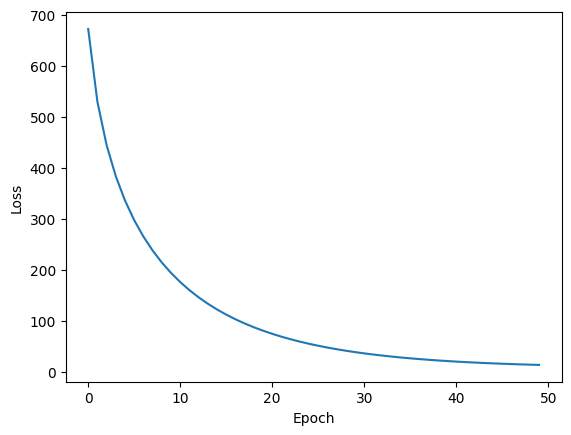

In [91]:
plt.plot(trainer.get_losses())
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

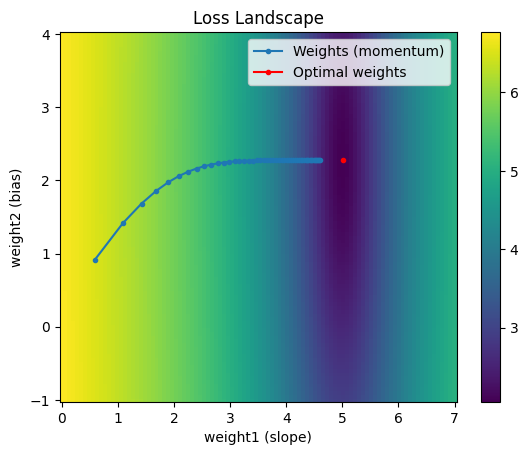

In [92]:
W1 = np.linspace(0, 7, 100)
W2 = np.linspace(-1, 4, 100)
log_loss = np.empty(shape=(100,100))

for i, w2 in enumerate(W2):
  for j, w1 in enumerate(W1):
    log_loss[i][j] = np.log(np.mean((w1*x + w2 - y)**2))


weights1, weights2 = np.meshgrid(W1, W2)
plt.pcolor(weights1, weights2, log_loss)
plt.colorbar()

# plot how gradient descent traversed the space
traversal = list(zip(*(optimizer.get_weights())))
plt.plot(traversal[0], traversal[1], marker='.', label='Weights (AdaGrad)')

# plot optimal weights
min_loss_idx = np.argmin(log_loss)
i,j = min_loss_idx//100, min_loss_idx%100
plt.plot(W1[j], W2[i], 'r', marker='.', label='Optimal weights')

plt.xlabel('weight1 (slope)')
plt.ylabel('weight2 (bias)')
plt.title('Loss Landscape')
plt.legend()
plt.show()

Note that we had to really bump up the learning rate to converge in a reasonable amount of time. The next optimizer will address this deficiency.

# RMSProp

RMSProp, short for Root Mean Squared Propagation, addresses the slowness of AdaGrad by decaying the sum of squared gradients such that the denominator of the term contributing to $\delta$ doesn't necessarily always increase.

$σ_i = (1-\lambda)g_i^2 + λ\sigma_{i-1}$

$\delta_i = -\gamma \frac{g_i}{\sqrt\sigma_i}$

$w_i = w_{i-1} + \delta_i$

In [95]:
class RMSPropOptimizer:
  def __init__(self, weights, lr, decay_rate):
    self.lr = lr
    self.weights = weights
    self.iterated_weights = [weights.copy()]
    self.grad_sq_sum = np.zeros_like(weights).reshape(1,-1)
    self.decay_rate = decay_rate

  def step(self, grad):
    # Update weights
    self.grad_sq_sum = (1 - self.decay_rate) * grad**2 + self.decay_rate * self.grad_sq_sum
    self.weights -= einops.rearrange(self.lr * grad/np.sqrt(self.grad_sq_sum), 'i j -> (i j)')

    # Keep track of weights for visualization
    self.iterated_weights.append(self.weights.copy())

  def get_weights(self):
    return self.iterated_weights

In [115]:
weights = initial_weights.copy()
optimizer = RMSPropOptimizer(weights, lr=0.1, decay_rate=0.99)
trainer = LinearModelTrainer(data, optimizer, num_epochs=50)
trainer.train()

In [116]:
print("final weights: ", optimizer.get_weights()[-1])
print("final grads: ", trainer.get_grad())

final weights:  [5.00268283 2.27463993]
final grads:  [[-1.04462827e-01  6.10622664e-16]]


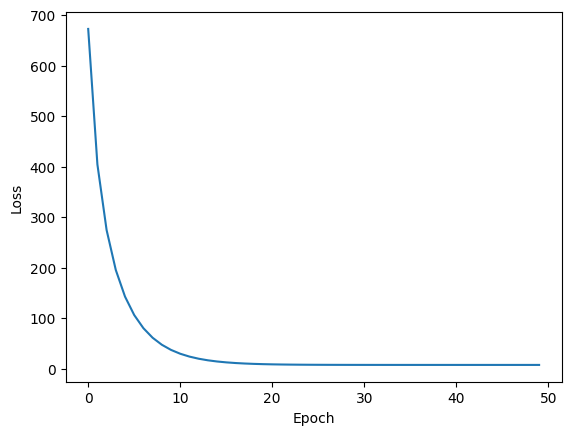

In [117]:
plt.plot(trainer.get_losses())
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

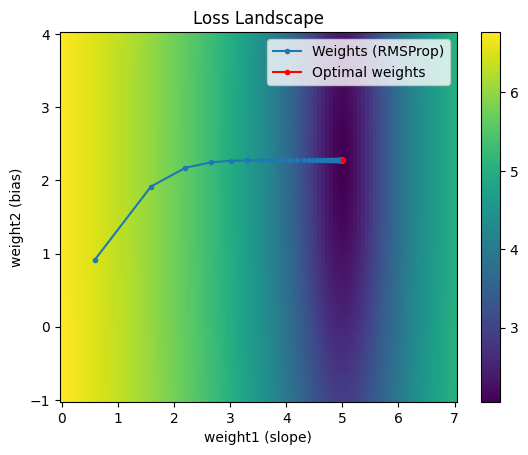

In [118]:
W1 = np.linspace(0, 7, 100)
W2 = np.linspace(-1, 4, 100)
log_loss = np.empty(shape=(100,100))

for i, w2 in enumerate(W2):
  for j, w1 in enumerate(W1):
    log_loss[i][j] = np.log(np.mean((w1*x + w2 - y)**2))


weights1, weights2 = np.meshgrid(W1, W2)
plt.pcolor(weights1, weights2, log_loss)
plt.colorbar()

# plot how gradient descent traversed the space
traversal = list(zip(*(optimizer.get_weights())))
plt.plot(traversal[0], traversal[1], marker='.', label='Weights (RMSProp)')

# plot optimal weights
min_loss_idx = np.argmin(log_loss)
i,j = min_loss_idx//100, min_loss_idx%100
plt.plot(W1[j], W2[i], 'r', marker='.', label='Optimal weights')

plt.xlabel('weight1 (slope)')
plt.ylabel('weight2 (bias)')
plt.title('Loss Landscape')
plt.legend()
plt.show()

Note the trajectory taken by RMSProp is very similar to that of AdaGrad. However we were able to achieve a better result in the same number of epochs with a lower learning rate. This was possible because we didn't allow the sum of squared gradients to grow unbounded - it was slightly decayed at each iteration, adding on a tiny amount of the current gradient squared.

# Adam

Finally, Adam, short for Adaptive Moment Estimation, combines the effects of Momentum and RMSProp. It's typically the go-to optimizer for training deep neural networks.

$\mu_{i} = (1-\lambda_1)g_{i} + λ_1\mu_{i-1}$

$σ_i = (1-\lambda_2)g_i^2 + λ_2\sigma_{i-1}$

$\delta_i = -\gamma \frac{\mu_i}{\sqrt\sigma_i}$

$w_i = w_{i-1} + \delta_i$

In [119]:
class AdamOptimizer:
  def __init__(self, weights, lr, decay_rate_grad, decay_rate_grad_sq):
    self.lr = lr
    self.weights = weights
    self.iterated_weights = [weights.copy()]
    self.grad_sq_sum = np.zeros_like(weights).reshape(1,-1)
    self.decay_rate_grad = decay_rate_grad
    self.decay_rate_grad_sq = decay_rate_grad_sq
    self.grad_sum = np.zeros_like(weights).reshape(1,-1)
    self.grad_sq_sum = np.zeros_like(weights).reshape(1,-1)

  def step(self, grad):
    # Update weights
    self.grad_sum = (1 - self.decay_rate_grad) * grad + self.decay_rate_grad * self.grad_sum
    self.grad_sq_sum = (1 - self.decay_rate_grad_sq) * grad**2 + self.decay_rate_grad_sq * self.grad_sq_sum
    self.weights -= einops.rearrange(self.lr * self.grad_sum/np.sqrt(self.grad_sq_sum), 'i j -> (i j)')

    # Keep track of weights for visualization
    self.iterated_weights.append(self.weights.copy())

  def get_weights(self):
    return self.iterated_weights

In [137]:
weights = initial_weights.copy()
optimizer = AdamOptimizer(weights, lr=0.1, decay_rate_grad=0.9, decay_rate_grad_sq=0.99)
trainer = LinearModelTrainer(data, optimizer, num_epochs=50)
trainer.train()

In [138]:
print("final weights: ", optimizer.get_weights()[-1])
print("final grads: ", trainer.get_grad())

final weights:  [5.32749386 2.36656698]
final grads:  [[23.63626372  0.19332335]]


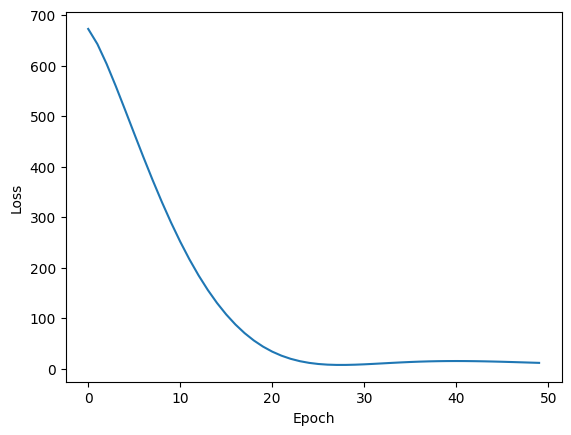

In [139]:
plt.plot(trainer.get_losses())
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

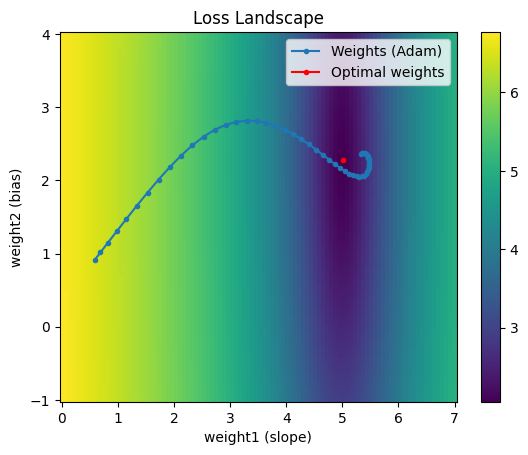

In [141]:
W1 = np.linspace(0, 7, 100)
W2 = np.linspace(-1, 4, 100)
log_loss = np.empty(shape=(100,100))

for i, w2 in enumerate(W2):
  for j, w1 in enumerate(W1):
    log_loss[i][j] = np.log(np.mean((w1*x + w2 - y)**2))


weights1, weights2 = np.meshgrid(W1, W2)
plt.pcolor(weights1, weights2, log_loss)
plt.colorbar()

# plot how gradient descent traversed the space
traversal = list(zip(*(optimizer.get_weights())))
plt.plot(traversal[0], traversal[1], marker='.', label='Weights (Adam)')

# plot optimal weights
min_loss_idx = np.argmin(log_loss)
i,j = min_loss_idx//100, min_loss_idx%100
plt.plot(W1[j], W2[i], 'r', marker='.', label='Optimal weights')

plt.xlabel('weight1 (slope)')
plt.ylabel('weight2 (bias)')
plt.title('Loss Landscape')
plt.legend()
plt.show()

Adam has two decay rate parameters to tune. It combines the speed of momentum with the ability to change directions from RMSProp. Depending on how the hyperparameters are chosen, the trajectory from Adam can vary quite a bit.

# References


https://blog.paperspace.com/intro-to-optimization-momentum-rmsprop-adam/

https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c

https://www.cs.toronto.edu/~jmartens/docs/Deep_HessianFree.pdf
